In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tag import StanfordPOSTagger
from nltk import word_tokenize
from nltk.internals import find_jars_within_path
import nltk
import sklearn.model_selection
from collections import Counter
import sklearn.feature_extraction.text as skt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import io
import re
import string
import tqdm
#import tensorflow as tf
#from tensorflow.keras import layers

#import torch
#import transformers

import pyhealth
from pyhealth.medcode import InnerMap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords as STOP_WORDS

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import f1_score

import gensim.models.word2vec as w2v

# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# import tensorflow as tf
# import torch
# from tensorflow.keras import layers


In [14]:
root = "/Users/ashleyroakes/Desktop/"
#root = "C:/Users/mab28/Documents/Workspace/School/CSE 6250 Big Data Health/project/our_code/data/"

mim_root = root + "mimic-iii-clinical-database-1.4/"


# Data Pre-processing
## Read in Discharge Notes

In [15]:
notes = mim_root + "NOTEEVENTS.csv.gz"

notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False, 
                       usecols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION','TEXT'])\
                      .query("CATEGORY == 'Discharge summary'")\
                      .query("DESCRIPTION == 'Report'")

# Should be 55,177 records
print("Number of discharge summaries: ", + len(notes_df))

notes_df.head()

<ipython-input-15-44e46582d5d0>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False,


Number of discharge summaries:  55177


,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
0,22532,167853.0,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Report,Admission Date: [**2162-3-3**] D...


## Read in Patient Diagnoses

In [16]:
diag = mim_root + "DIAGNOSES_ICD.csv.gz"

diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\
                    .dropna()\
                    .groupby('HADM_ID')['ICD9_CODE']\
                    .unique()\
                    .reset_index()

diag_df.head()

<ipython-input-16-9a3e874e7dee>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\


,HADM_ID,ICD9_CODE
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ..."
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,..."
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V..."
3,100007,"[56081, 5570, 9973, 486, 4019]"
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148..."


## Read in ICD9 Dictionary

In [17]:
icd = mim_root + "D_ICD_DIAGNOSES.csv.gz"
icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)


icd_df.head()

<ipython-input-17-fb0e33a27e31>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## Merge datasets by HADM_ID

In [18]:
df = pd.merge(diag_df, notes_df, on='HADM_ID', how='inner')

# Should be 55177-5 = 55172
len(df)

55172

## Substitute special sequences & Filter HoPI sections

### Identify HOPI sections & Substitute Special Sequences

In [19]:
def process_notes(st):
    s  = "History of Present Illness"
    s1 = "HISTORY OF PRESENT ILLNESS|HISTORY OF THE PRESENT ILLNESS|\nHISTORY:|present illness|Present Illness|PRESENT ILLNESS"
    
    match  = re.search(s, st)
    match1 = re.search(s1, st)
    
    if (match is not None) or (match1 is not None):
        if match is not None:
            st = st.split(s, 1)[1]
            e = "\n\n\n"
            n = st.split(e, 1)[0]
    
        elif match1 is not None: 
            st = st.split(match1[0], 1)[1]
            e = re.search(r"\n[\s\w]+:", st)[0]
            n = st.split(e, 1)[0]
        
        # Replace special strings with ""
        rep = re.findall(r"\[\*\*([a-zA-Z0-9]*)", n)
        strt = [m.start() for m in re.finditer("\[\*\*([a-zA-Z0-9]*)", n)]
        end = [m.end() for m in re.finditer("([a-zA-Z0-9]*)\*\*\]", n)]

        for i in range(len(rep)):
            n = n[:strt[i]] + rep[i] + " " + n[end[i] + 1:]
        
    else: 
        n = ''
    return n

In [20]:
df['HOPI'] = df["TEXT"].map(lambda t: process_notes(t))

df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('\[\*\*[^\]]*\*\*\]', '', x))
df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('<[^>]*>', '', x))
df["HOPI"] = df["HOPI"].apply(lambda x: re.sub('[\W]+', ' ', x))

# Detect history of present illness in text (n = 2641 records without HoPI data)
missing = len(df[df['HOPI'] == ""])
print("Number of docs missing HOPI sections: " + str(missing))

df = df[df["HOPI"] != ""].reset_index(drop = True)
df['SENT_TOKENS'] = df["HOPI"].map(lambda t: [p.lower() for p in nltk.RegexpTokenizer(r'\w+').tokenize(t) if not p.isnumeric()])


Number of docs missing HOPI sections: 1867


In [21]:
# Truncate to 500 tokens per HOPI
df["SENT_TOKENS"] = df["SENT_TOKENS"].map(lambda c: np.unique(c)[0:500])

df['SENT_TOKENS_COMBO'] = df["SENT_TOKENS"].map(lambda t: " ".join(t))
df.head()

,HADM_ID,ICD9_CODE,SUBJECT_ID,CATEGORY,DESCRIPTION,TEXT,HOPI,SENT_TOKENS,SENT_TOKENS_COMBO
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ...",58526,Discharge summary,Report,Admission Date: [**2117-9-11**] ...,35F w poorly controlled Type 1 diabetes melli...,"[325mg, 35f, 3l, 3rd, 4mg, 5d, a, ag, also, am...",325mg 35f 3l 3rd 4mg 5d a ag also am an and an...
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,...",54610,Discharge summary,Report,Admission Date: [**2150-4-17**] ...,Mr Known is a 59M w HepC cirrhosis c b grade ...,"[40mg, 4l, 59m, a, abdominal, about, abstain, ...",40mg 4l 59m a abdominal about abstain admissio...
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V...",9895,Discharge summary,Report,Admission Date: [**2108-4-6**] Discharg...,This is a 48 year old African American female...,"[a, abdominal, abg, admitted, african, ago, al...",a abdominal abg admitted african ago albuterol...
3,100007,"[56081, 5570, 9973, 486, 4019]",23018,Discharge summary,Report,Admission Date: [**2145-3-31**] ...,Ms Known is a 73 year old female with a histo...,"[a, abdominal, and, appendectomy, back, began,...",a abdominal and appendectomy back began bowel ...
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148...",533,Discharge summary,Report,Admission Date: [**2162-5-16**] ...,60yo man with known coronary disease AMI in 2...,"[36mmhg, 60yo, a, admitted, ak, ami, and, angi...",36mmhg 60yo a admitted ak ami and angina anter...


In [11]:
sentences = df['SENT_TOKENS_COMBO'].map(lambda t: t.split()).values

model = w2v.Word2Vec(vector_size=200, min_count=5, workers=4, iter=5)

model.build_vocab(sentences)

model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)

model.save('./model\model.w2v')

wv = model.wv

vocab = model.wv.vocab

ind2w = {i+1:w for i,w in enumerate(sorted(vocab))}

PAD_CHAR = "**PAD**"

def build_matrix(ind2w, wv):
    W = np.zeros((len(ind2w)+1, len(wv.word_vec(wv.index2word[0])) ))
    words = [PAD_CHAR]
    W[0][:] = np.zeros(len(wv.word_vec(wv.index2word[0])))
    for idx, word in ind2w.items():
        if idx >= W.shape[0]:
            break    
        W[idx][:] = wv.word_vec(word)
        words.append(word)
    return W, words

W, words = build_matrix(ind2w, wv)

def save_embeddings(W, words, outfile):
    with open(outfile, 'w') as o:
        #pad token already included
        for i in range(len(words)):
            line = [words[i]]
            line.extend([str(d) for d in W[i]])
            o.write(" ".join(line) + "\n")

outfile = './model\model.embed'
save_embeddings(W, words, outfile)


TypeError: __init__() got an unexpected keyword argument 'iter'

In [ ]:
def load_embeddings(embed_file):
    #also normalizes the embeddings
    W = []
    with open(embed_file) as ef:
        for line in ef:
            line = line.rstrip().split()
            vec = np.array(line[1:]).astype(np.float)
            vec = vec / float(np.linalg.norm(vec) + 1e-6)
            W.append(vec)
        #UNK embedding, gaussian randomly initialized 
        print("adding unk embedding")
        vec = np.random.randn(len(W[-1]))
        vec = vec / float(np.linalg.norm(vec) + 1e-6)
        W.append(vec)
    W = np.array(W)
    return W

## Plot a histogram of the Number of tokens in each HoPI document, after data preprocessing.

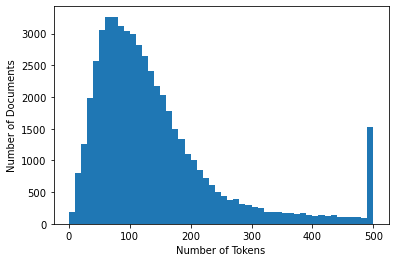

In [22]:
df["trunc_len"] = df['SENT_TOKENS'].map(lambda c: len(c))

plt.hist(df["trunc_len"], np.arange(0, 501, 10))
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Documents")
plt.show()

## Split data in train, valid, and test sets
### training (38,588 records, 69.9%), validation (5536 records, 10.0%) and testing (11,048 records, 20.0%) folds

In [25]:
# Random split
train, tst = sklearn.model_selection.train_test_split(df, test_size= 0.3, random_state=42)

test, valid = sklearn.model_selection.train_test_split(tst, test_size= 0.33, random_state=42)

train = train.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
test = test.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
valid = valid.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)

len(test)

10714

## Count number of tokens in the training dataset (n = ~92,468 tokens)

In [ ]:
# Count occurence of tokens that are in the training dataset
n = len(np.unique(np.concatenate(train['SENT_TOKENS'].values)))
occ = Counter(np.concatenate(train['SENT_TOKENS'].values))
             
# Tokens that occur >= 5 times are in the study vocabulary (should be ~19,503)
vocab = [k for k,v in occ.items() if v >= 5]
len(vocab)

# Assign a unique integer ID for each token in the study vocabulary 
vocab_lookup = dict(zip(vocab, np.arange(0, len(vocab), 1)))

# Convert each HoPI document to a 1D array of integers using this index
train["trunc_idx"] =  train['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
valid["trunc_idx"] =  valid['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
test["trunc_idx"] =  test['SENT_TOKENS'].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])

# Document representation

In [ ]:
# Represent clinical notes documents as TF-IDF weights
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

def tfidf(df):
    pipe = Pipeline([('count', CountVectorizer(vocabulary = vocab, lowercase = False)),('tfid', TfidfTransformer(use_idf=True))]).fit(df["HOPI"].values)
    pipe['count'].transform(df["HOPI"].values).toarray()
    pipe['tfid'].idf_

    return pipe.transform(df["HOPI"].values)

# Create sparse matrix of size number of docs x words in vocab
tfidf_train = tfidf(train)
tfidf_valid = tfidf(valid)
tfidf_test = tfidf(test)

In [ ]:
# Mean embedding representation

In [ ]:
# GRU representation

# Label representation

### Identify the hierarchical labels for each icd9 code

In [ ]:
# Pull out the main ICD9 code (they are ordered for importance)
train["ICD_Main"] = train['ICD9_CODE'].map(lambda x: x[0])
valid["ICD_Main"] = valid['ICD9_CODE'].map(lambda x: x[0])
test["ICD_Main"] = test['ICD9_CODE'].map(lambda x: x[0])

In [ ]:
# Use pyhealth library to find code hierarchy for the train, test, and valid datasets
icd9cm = InnerMap.load("ICD9CM")

def define_levels(x):
    lvls = []
    for l in x: 
        lvls.append(icd9cm.lookup(l))
    return lvls

def drop_top(X):
    if '001-999.99' in X:
        X.remove('001-999.99')
    return X

def get_codes(df):
    #df['icd_desc'] = df['ICD_Main'].map(lambda x: icd9cm.lookup(x))
    df['levels'] = df['ICD_Main'].map(lambda x:icd9cm.get_ancestors(x)[::-1])
    df['levels'].map(lambda x: drop_top(x))

    for i in range(len(df)):
        df['levels'][i].append(df['ICD_Main'][i])

    df['levels_desc'] = df['levels'].map(lambda x: define_levels(x))

get_codes(train)
get_codes(valid)
get_codes(test)

In [ ]:
# Append the code descriptions to the dfs
train_labs = pd.concat([train, train['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4", 4:"y_l5", 5:"y_l6"})
valid_labs = pd.concat([valid, valid['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4", 4:"y_l5", 5:"y_l6"})
test_labs = pd.concat([test, test['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1)\
    .rename(columns={0: "y_l1", 1: "y_l2", 2: "y_l3", 3: "y_l4" , 4:"y_l5", 5:"y_l6"})

## Baseline Model

### TFIDF-Atomic: TFIDF document weights were input into a multinomical logistic regression classifier in order to predict the 4 levels of icd hierarchy

### Precict level 1 icd9 codes

In [ ]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over
L2 = np.logspace(.01, 100, num = 50)

# # Enumerate the l1 classes
y_l1_dict = dict(zip(np.unique(train_labs['y_l1'].values), np.arange(0, len(np.unique(train_labs['y_l1'].values)), 1)))
y_l1_trn = train_labs['y_l1'].map(lambda x: y_l1_dict.get(x))
y_l1_val = valid_labs['y_l1'].map(lambda x: y_l1_dict.get(x))
y_l1_tst = test_labs['y_l1'].map(lambda x: y_l1_dict.get(x))

# Use the validation data to determine the best model parameter for C
scores = []
for C in L2: 
    tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = C)
    tfidf_atomic_L1 = tfidf_atomic.fit(tfidf_train, y_l1_trn)
    y_v_pred = tfidf_atomic_L1.predict(tfidf_valid)
    report = metrics.classification_report(y_l1_val, y_v_pred, digits = 3, output_dict=True)
    scores.append((C, report['weighted avg']['recall']))

# C value for best model on valid data
best_C = max(scores,key=lambda x:x[1])[0]

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l1 = tfidf_atomic.fit(tfidf_train, y_l1_trn)
y_pred = tfidf_atomic_l1.predict(tfidf_test)
L1_test_report = metrics.classification_report(y_l1_tst, y_pred, digits = 3, output_dict=True)
L1_test_report['weighted avg']

NameError: name 'np' is not defined

### Precict level 2 icd9 codes

In [ ]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over
L2 = np.logspace(.01, 100, num = 50)
#L2 = [100]

# # Enumerate the l1 classes
y_l2_dict = dict(zip(np.unique(train_labs['y_l2'].values), np.arange(0, len(np.unique(train_labs['y_l2'].values)), 1)))
y_l2_trn = train_labs['y_l2'].map(lambda x: y_l2_dict.get(x))
y_l2_val = valid_labs['y_l2'].map(lambda x: y_l2_dict.get(x))
y_l2_tst = test_labs['y_l2'].map(lambda x: y_l2_dict.get(x))

# Use the validation data to determine the best model parameter for C
scores = []
for C in L2: 
    tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = C)
    tfidf_atomic_L2 = tfidf_atomic.fit(tfidf_train, y_l2_trn)
    y_v_pred = tfidf_atomic_L2.predict(tfidf_valid)
    report = metrics.classification_report(y_l2_val, y_v_pred, digits = 3, output_dict=True)
    scores.append((C, report['weighted avg']['recall']))

# C value for best model on valid data
best_C = max(scores,key=lambda x:x[1])[0]

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l2 = tfidf_atomic.fit(tfidf_train, y_l2_trn)
y_pred = tfidf_atomic_l2.predict(tfidf_test)
L2_test_report = metrics.classification_report(y_l2_tst, y_pred, digits = 3, output_dict=True)
L2_test_report['weighted avg']

### Precict level 3 icd9 codes

In [ ]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over
L2 = np.logspace(.01, 100, num = 50)

# # Enumerate the l1 classes
y_l3_dict = dict(zip(np.unique(train_labs['y_l3'].values), np.arange(0, len(np.unique(train_labs['y_l3'].values)), 1)))
y_l3_trn = train_labs['y_l3'].map(lambda x: y_l3_dict.get(x))
y_l3_val = valid_labs['y_l3'].map(lambda x: y_l3_dict.get(x))
y_l3_tst = test_labs['y_l3'].map(lambda x: y_l3_dict.get(x))

# Use the validation data to determine the best model parameter for C
scores = []
for C in L2: 
    tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = C)
    tfidf_atomic_L3 = tfidf_atomic.fit(tfidf_train, y_l3_trn)
    y_v_pred = tfidf_atomic_L3.predict(tfidf_valid)
    report = metrics.classification_report(y_l3_val, y_v_pred, digits = 3, output_dict=True)
    scores.append((C, report['weighted avg']['recall']))

# C value for best model on valid data
best_C = max(scores,key=lambda x:x[1])[0]

# Get results on test data for best model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42, C = best_C)
tfidf_atomic_l3 = tfidf_atomic.fit(tfidf_train, y_l3_trn)
y_pred = tfidf_atomic_l3.predict(tfidf_test)
L3_test_report = metrics.classification_report(y_l3_tst, y_pred, digits = 3, output_dict=True)
L3_test_report['weighted avg']

### Mean-atomic

### GRU(X) - atomic

In [1]:
# GRU with softmax activation?

NameError: name 'scores' is not defined

### GRU(X) - GRU(Z)